In [ ]:
%pwd 
!pip install gdown
!pip install utillc
%mkdir -p data
%cd /content/data

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1BPrMZagw_SD0tB3TrtTcXeclzhpGtAro/view?usp=sharing
!unzip archive.zip

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from utillc import *
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

without qt5
no qt5


In [ ]:
# load data
image_data = np.load('/content/data/face_images.npz')
image = image_data['face_images']
image = np.transpose(image,(2,0,1))
image.shape

(7049, 96, 96)

In [ ]:
face_data = pd.read_csv('/content/data/facial_keypoints.csv')
# some data do not have all 15 landmark label, they will be excluded from dataset
full_data = face_data.dropna()
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2140 entries, 0 to 2283
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [ ]:
# randomly select 9 images from the dataset and do the visualization
sample_index = random.sample(list(full_data.index),9)
sample_label = full_data.loc[sample_index].values
sample_image = image[sample_index]

In [ ]:
# function to split x and y into list
def split_x_y(sample_label,denormalize=False):
    sample_x = []
    sample_y = []
    for label in sample_label:
        # extract x, y from labels
        x = [label[i] for i in range(0,len(sample_label[0]),2)]
        y = [label[i] for i in range(1,len(sample_label[0])+1,2)]
        # store x and y into list respectively
        sample_x.append(x)
        sample_y.append(y)
    if denormalize:
        # label will be devided by 96 to range betweent 0 and 1 during training, so the label need to be reversed for visualization
        sample_x = np.array(sample_x)*96
        sample_y = np.array(sample_y)*96
    return sample_x, sample_y

sample_x, sample_y = split_x_y(sample_label)

<ipython-input-27-17640cff3372>:11: [27862ms] sample_image.shape=(9, 96, 96).


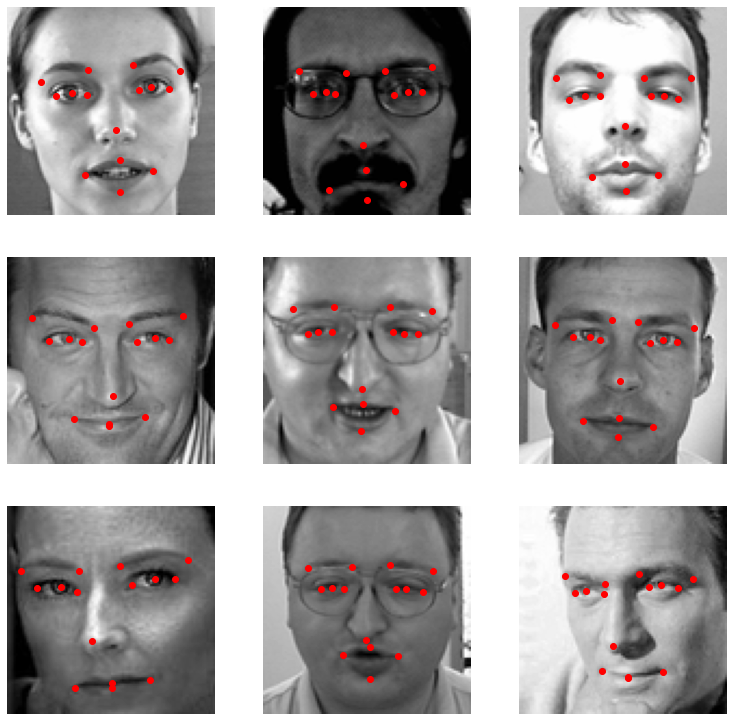

In [ ]:
# function to visualize data
def plot_sample(axs, image, x, y,pred=False, pred_x=None, pred_y=None):
    [ax.imshow(image,cmap='gray') for ax,image in zip(axs.ravel(),image)]
    [ax.plot(x,y,'ro') for ax,x,y in zip(axs.ravel(),x, y)]
    if pred:
        [ax.plot(x,y,'bo') for ax,x,y in zip(axs.ravel(),pred_x, pred_y)]
    [ax.axis('off') for ax in axs.ravel()];

utillc.print_everything()   
fig, axs = plt.subplots(3,3,figsize=(13,13))
EKOX(sample_image.shape)
plot_sample(axs, sample_image, sample_x, sample_y)

In [ ]:
class FaceDataset(Dataset):
    def __init__(self, image, label):
        self.image = image
        self.label = label
    def __len__(self):
        return len(self.image)
    def __getitem__(self,idx):
        img = self.image[idx]
        img = img/255.
        
        label = self.label[idx]
        label = label/96.
        
        img = torch.as_tensor(img, dtype=torch.float32)
        label = torch.as_tensor(label, dtype=torch.float32)
        return img, label

In [ ]:
# select image with all the labels, and expand dim from (batch_size, width, height) -> (batch_size, channels, width, height)
X = np.expand_dims(image[full_data.index],1)
y = full_data.values

# split into train, val set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.1)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(1926, 1, 96, 96) (214, 1, 96, 96) (1926, 30) (214, 30)


In [ ]:
# parameter
BATCH_SIZE=32
device = torch.device('cuda')
lr_rate = 1e-4
EPOCH = 20

In [ ]:
train_dataset = FaceDataset(X_train, y_train)
train_data_loader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=2)
val_dataset = FaceDataset(X_val, y_val)
val_data_loader = DataLoader(val_dataset,
                              batch_size=BATCH_SIZE,
                              num_workers=2)

In [ ]:
# check the train_data_loader
image_check, label_check = next(iter(train_data_loader))
print(image_check.shape, label_check.shape)

torch.Size([32, 1, 96, 96]) torch.Size([32, 30])


In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
# will be used for building model
class CNNBlock(nn.Module):
    def __init__(self,in_feature, out_feature):
        super().__init__()
        self.cnn = nn.Conv2d(in_feature,out_feature,3)
        self.bn = nn.BatchNorm2d(out_feature)
        self.maxpool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout2d(.2)
    def forward(self,x):
        x = self.cnn(x)
        x = self.bn(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        return x
    
class FaceLandmarkDectionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1 = CNNBlock(1,64)
        self.cnn2 = CNNBlock(64,128)
        self.cnn3 = CNNBlock(128,512)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512*10*10,1024)
        self.fc2 = nn.Linear(1024,512)
        self.out = nn.Linear(512,30)
    def forward(self,x):
        x = self.cnn1(x)
        x = self.cnn2(x)
        x = self.cnn3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = torch.sigmoid(self.out(x))
        return x

In [ ]:
# load a random input to check the model
model = FaceLandmarkDectionModel()
x_check = torch.as_tensor(np.random.randn(1,1,96,96),dtype=torch.float32)
model(x_check).shape

torch.Size([1, 30])

In [ ]:
def train_fn(data_loader, model, optimizer, criterion, device, epoch):
    model.train()
    
    # class to save loss
    summary_loss = AverageMeter()
    tk0 = tqdm(data_loader, total=len(data_loader))
    for step, (images, labels) in enumerate(tk0):
        images = images.to(device, non_blocking=True).float()
        labels = labels.to(device, non_blocking=True).float()
        
        # make prediction
        outputs = model(images)
        # calculate loss
        loss = criterion(outputs, labels)
        
        # update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # save loss value
        summary_loss.update(loss.item(), BATCH_SIZE)
        tk0.set_postfix(loss=summary_loss.avg, epoch=epoch+1)
    return summary_loss

def eval_fn(data_loader, model, criterion, device, epoch):
    model.eval()
    
    # class to save loss
    summary_loss = AverageMeter()
    tk0 = tqdm(data_loader, total=len(data_loader))
    for step, (images, labels) in enumerate(tk0):
        images = images.to(device, non_blocking=True).float()
        labels = labels.to(device, non_blocking=True).float()
        
        # make prediction
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # save loss value
        summary_loss.update(loss.item(), BATCH_SIZE)
        tk0.set_postfix(loss=summary_loss.avg,epoch=epoch+1)
    return summary_loss

In [ ]:
def run():
    # Load pretrained model
    model = FaceLandmarkDectionModel()
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(),lr=lr_rate)
    # Set loss function
    criterion = nn.L1Loss()
    best_loss = 10**5
    for epoch in range(0,EPOCH):
        train_loss = train_fn(train_data_loader, model, optimizer, criterion, device, epoch)
        val_loss = eval_fn(val_data_loader, model, criterion, device, epoch)
        # Check if val_loss is less than best_loss
        if val_loss.avg < best_loss:
            # Update best loss
            best_loss = val_loss.avg
            # Save model
            torch.save(model.state_dict(), f'best.pth')

In [ ]:
# run the model
run()

100%|██████████| 7/7 [00:00<00:00, 15.14it/s, epoch=20, loss=0.0169]


In [ ]:
# load the model with lowest val loss
model = FaceLandmarkDectionModel()
model.load_state_dict(torch.load("./best.pth"))

<All keys matched successfully>

In [ ]:
# visualize val data
val_image, val_label = next(iter(val_data_loader))
EKOX(val_image.shape)
# predict face landmark point
pred_label = model(val_image)

# rearrange the dimension (batch_size, channels, width, height) -> (batch_size, width, height, channels)
val_image = np.transpose(val_image.detach().numpy(),(0,2,3,1))
val_image = val_image[:,:,:,0]
EKOX(val_image.shape)

# split label in to x and y
pred_x, pred_y = split_x_y(pred_label.detach().numpy(),denormalize=True)
true_x, true_y = split_x_y(val_label.detach().numpy(),denormalize=True)

<ipython-input-31-63dda02c2990>:3: [15091ms] val_image.shape=torch.Size([32, 1, 96, 96]).
<ipython-input-31-63dda02c2990>:10: [0836ms] val_image.shape=(32, 96, 96).


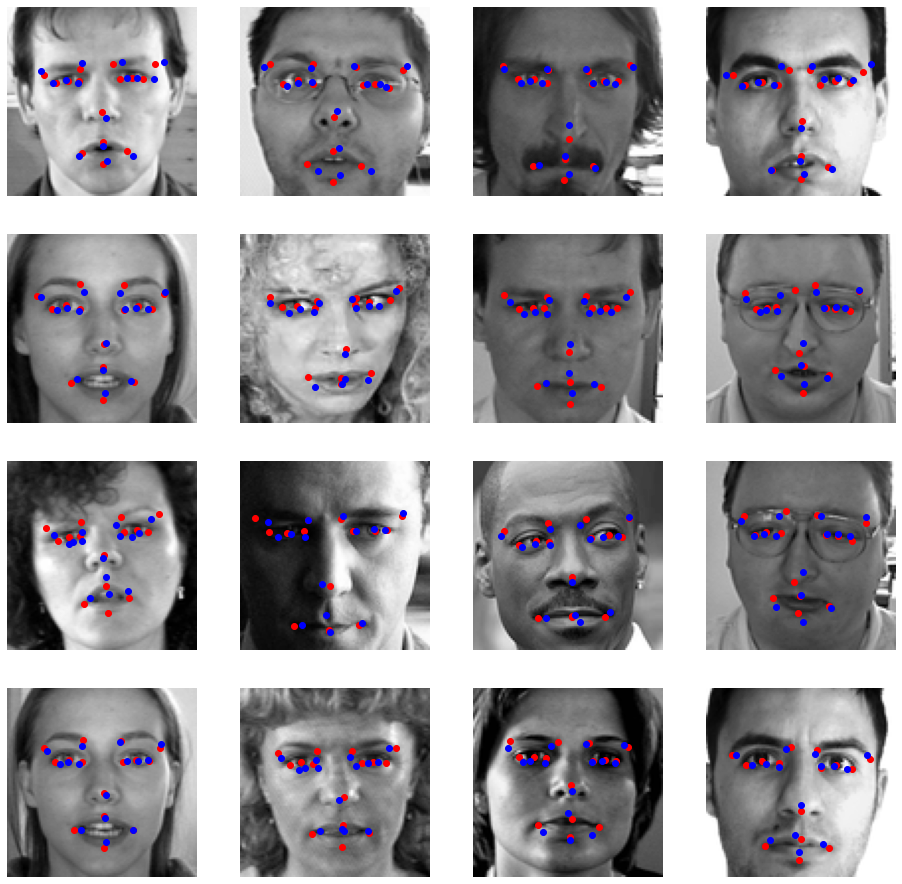

In [ ]:
# visualize image
fig, axs = plt.subplots(4,4,figsize=(16,16))
plot_sample(axs, val_image, true_x, true_y,True, pred_x, pred_y)

# a faire

- ecrire une fonction qui affiche le rmse cad :
$1/N \sum_i{(\hat{y}_i - y_i)^2}$ 
- améliorer le rmse en 'augmentant les données avec la librairie albumentation

- transformer cette tache de régression en utilisant les heat maps